In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import io
import math

In [2]:
class Neuron:
    def __init__(self, potential, position, size, color='black', reset_potential=-1):
        self.position = position
        self.size = size
        self.color = color
        self.reset_potential = reset_potential
        self.potential = potential
        self.spiking = np.random.rand() > 0.5
        self.firing_rate = int(self.spiking) 
        self.nspikes = int(self.spiking)
        if self.spiking: self.potential = reset_potential
        
    def determine_neuron_color(self):
            if self.spiking: 
                color = 'green' 
                self.nspikes += 1
            else: 
                voltage_normalized = (self.potential + 1) / 2
                color_rgb = plt.cm.winter(voltage_normalized)[:3]
                color = color_rgb
            return color
        
        

In [74]:
class Network:
    def __init__(self, N=60, tfr = 0.01, sandbox_size=(1000, 1000), size_range=(5, 50)):
        
        self.N = N
        self.sandbox_size = sandbox_size
        self.size_range = size_range
        self.neurons = self.init_neurons()
        
        self.M = self.init_connectivity_matrix()
        self.triu = np.triu_indices_from(self.M, k=1)
        self.trili = np.tril_indices_from(self.M, k=-1)
        self.update_connectivity_matrix()# evolving connectivity matrix M
        
        self.tfr = tfr # target firing rate
        self.growth_coeff = 0.01
        self.t = 0
      

    def init_connectivity_matrix(self):
        M = np.random.rand(self.N, self.N)
        M = M - np.transpose(M)
        np.fill_diagonal(M, 0)
        M = M / np.sum(abs(M))
        return M


    def init_neurons(self):
        sandbox_width, sandbox_height = self.sandbox_size
        neurons = []
        for _ in range(self.N):
            potential = 2*np.random.rand()-1
            position = tuple(np.random.rand(2) * [sandbox_width, sandbox_height])
            size = np.random.uniform(self.size_range[0], self.size_range[1])
            color = 'black'
            neurons.append(Neuron(potential, position, size, color))
        return neurons
          
            
    def check_overlap(self, neuron1, neuron2):
        distance_squared = (neuron1.position[0] - neuron2.position[0])**2 + (neuron1.position[1] - neuron2.position[1])**2
        return (neuron1.size + neuron2.size)**2 > distance_squared


    def circle_overlap_area(self, neuron1, neuron2):
        x1, y1, r1 = neuron1.position[0], neuron1.position[1], neuron1.size
        x2, y2, r2 = neuron2.position[0], neuron2.position[1], neuron2.size
        d = ((x2 - x1)**2 + (y2 - y1)**2)
        
        if d <= (r1 - r2)**2 and r1 >= r2:
            return math.pi * r2**2
        
        elif d <= (r1 - r2)**2 and r1 < r2:
            return math.pi * r1**2
        
        else:
            d = math.sqrt(d)
            h = (1/(2*d))*math.sqrt(2*(d**2)*(r1**2)+2*(d**2)*(r2**2) + 2*(r1**2)*(r2**2)-d**4 - r1**4 - r2**4)
            
            return (r1**2)*math.asin(h/r1)+(r2**2)*math.asin(h/r2) - d*h
    
    
    def update_connectivity_matrix(self):
        
        for k in range(len(self.triu[0])):
            i = self.triu[0][k]
            j = self.triu[1][k]
            
            if self.check_overlap(self.neurons[i], self.neurons[j]):
                overlap_area = self.circle_overlap_area(self.neurons[i], self.neurons[j])
                self.M[i][j] = overlap_area/(math.pi*(self.size_range[1])**2)
            else: 
                self.M[i][j] = 0
                      
        self.M[self.trili] = -self.M[self.triu]
                        
        
    def get_firing_rate(self, spikes_list, itn, neuron_index, window_size):
        
        spike = 0
        
        for i in range(window_size):
            spike += spikes_list[itn-window_size+i][neuron_index].astype(int)
        firing_rate = spike/window_size

        return firing_rate



    def simulate(self, iterations, dt = 0.1, spike_input=0.5, input_noise = 0.1, leak=0.01, spike_threshold = 1, REST=-1, animate=True):
        spikes_list = []
        V_list = []
        firing_rates_list = []
        size_list = []
        
        V = [neuron.potential for neuron in self.neurons]
        spikes = [neuron.spiking for neuron in self.neurons]
        
        if animate:
            fig, ax = plt.subplots()
            frames = []
        
        for itn in range(iterations):
            # Updating V (potential) and determining which neurons spiked
            V = np.array(V) + spike_input*np.dot(self.M, spikes) + input_noise * np.random.rand(self.N) - leak * np.array(V)
            spikes = (V >= spike_threshold)
            V[spikes] = REST
            V[V < REST] = REST

            # Updating neuron object attributes for neurons in network
            for i, neuron in enumerate(self.neurons):
                neuron.spiking = spikes[i]
                neuron.potential = V[i]
                neuron.color = neuron.determine_neuron_color()
                neuron.spiking = False
                
                neuron.firing_rate = neuron.nspikes / (itn + 1)
                
                #if itn > int(1/self.tfr):
                #    neuron.firing_rate = self.get_firing_rate(spikes_list, itn, i, window_size = int(1/self.tfr))
                
                if neuron.firing_rate < self.tfr:
                    #neuron.size *= (2-(neuron.size / self.size_range[1]))
                    neuron.size *= (1 + self.growth_coeff)
                elif neuron.firing_rate >= self.tfr: 
                    #neuron.size *= (neuron.size / self.size_range[1])
                    neuron.size *= (1 - self.growth_coeff)
                if neuron.size > self.size_range[1]: neuron.size = self.size_range[1]
                if neuron.size < self.size_range[0]: neuron.size = self.size_range[0]
            

            self.update_connectivity_matrix()
            firing_rates = [neuron.firing_rate for neuron in self.neurons]
            neuron_sizes = [neuron.size for neuron in self.neurons]
            mean_firing_rate = np.mean(np.array(firing_rates))
            self.t += dt
            #self.tfr = mean_firing_rate
            
                
            # Updating global lists (keep track of all attributes for every iteration)
            V_list.append(V.copy())
            spikes_list.append(spikes.copy())
            firing_rates_list.append(firing_rates.copy())
            size_list.append(neuron_sizes.copy())                
            
            if animate:
                ax.clear()
                for neuron in self.neurons:
                    circle = plt.Circle(neuron.position, neuron.size, color=neuron.color, alpha=0.5)
                    ax.add_artist(circle)
                ax.set_xlim(0, self.sandbox_size[0])
                ax.set_ylim(0, self.sandbox_size[1])
                ax.set_aspect('equal')
                ax.axis('off')
                buf = io.BytesIO()
                fig.savefig(buf, format='png')
                buf.seek(0)
                frames.append(imageio.imread(buf))


        if animate:
            imageio.mimsave('area_plasticity.gif', frames, duration=0.1)
        
        print('mean firing rate:', mean_firing_rate)    
        return spikes_list, V_list, firing_rates_list, size_list
        

In [78]:
class Graphics:
    
    def draw(self, network):
        fig, ax = plt.subplots(figsize=(10, 10))
        for neuron in network.neurons:
            circle = plt.Circle(neuron.position, neuron.size, color=neuron.color, alpha=0.5)
            ax.add_artist(circle)
        ax.set_xlim(0, network.sandbox_size[0])
        ax.set_ylim(0, network.sandbox_size[1])
        ax.set_aspect('equal')
        ax.axis('off')

    def plot_neuron_activity(self, spikes_list, V_list):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(spikes_list).T, aspect='auto')
        plt.xlabel('Time')
        plt.ylabel('Neuron Index')
        plt.title('Neuron Firings Over Time')
        plt.subplot(1, 2, 2)
        plt.imshow(np.array(V_list).T, aspect='auto', cmap='winter')
        plt.xlabel('Time')
        plt.ylabel('Neuron index')
        plt.title('Membrane Potential Over Time')
        plt.colorbar(label='Membrane Potential')
        plt.tight_layout()
        plt.show()
        
    def plot_M(self, network):
        plt.figure()
        plt.imshow(network.M)
        colorbar = plt.colorbar()
        colorbar.set_label('Synaptic Connection Strength')
        plt.xlabel('Neuron index')
        plt.ylabel('Neuron index')
        plt.title('Connectivity Matrix M')

    def plot_firing_rates(self, network, firing_rates_list):
        plt.figure()
        fr_img = plt.imshow(np.array(firing_rates_list).T, aspect='auto')
        plt.colorbar(fr_img)
        fr_img.set_clim(0, 1.5 * network.tfr)
        plt.title(f'Neuron firing rates, tfr = {network.tfr}')
        plt.xlabel('Iteration #')
        plt.ylabel('Neuron index')
        
    def plot_neuron_sizes(self, network, size_list):
        plt.figure()
        sz_img = plt.imshow(np.array(size_list).T, aspect='auto')
        plt.colorbar(sz_img)
        sz_img.set_clim(0, network.size_range[1])
        plt.title(f'Neuron radii, size range: {network.size_range}')
        plt.xlabel('Iteration #')
        plt.ylabel('Neuron index')

mean firing rate: 0.00534


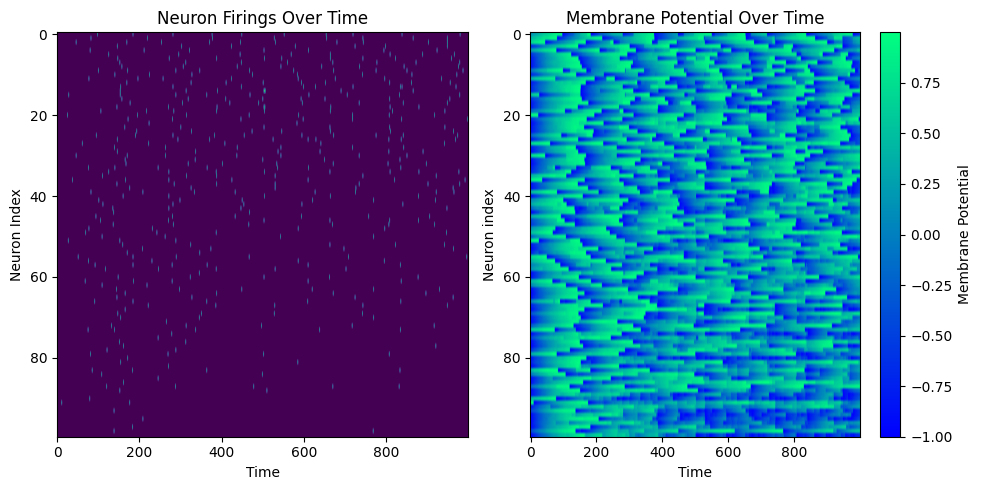

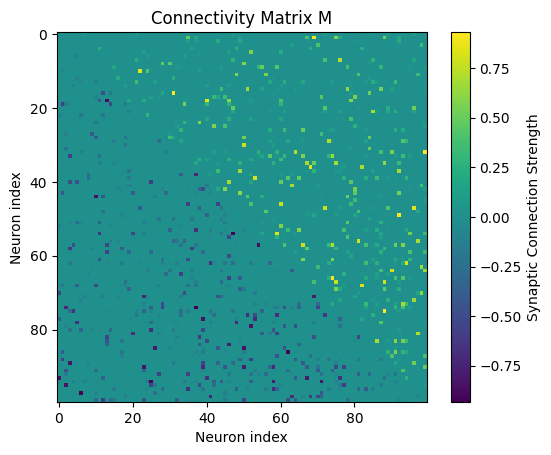

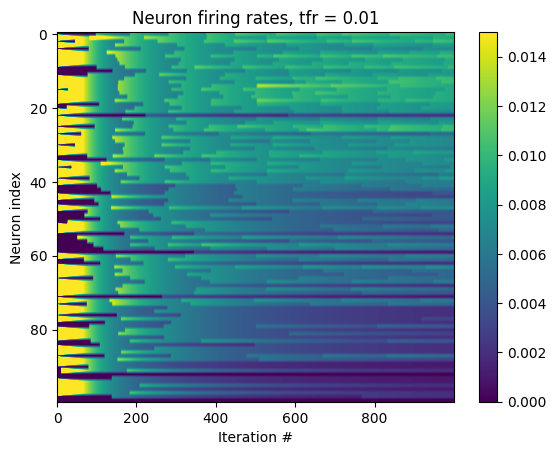

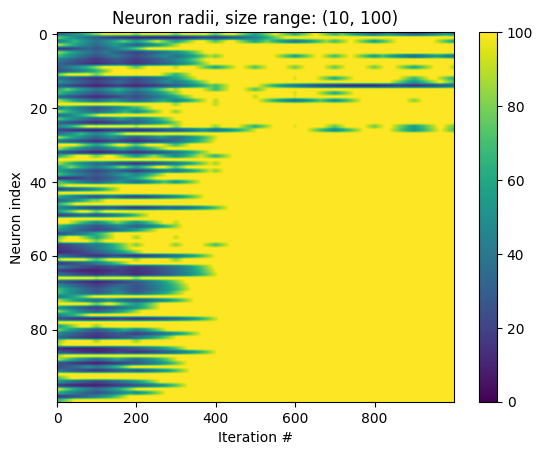

In [81]:
network = Network(N=100, sandbox_size = (1000,1000), tfr = 0.01, size_range=(10,100))
graphics = Graphics()

network.init_neurons()
#graphics.draw(network)

spikes_list, V_list, firing_rates_list, size_list = network.simulate(iterations = 1000, spike_input=1, input_noise=0.03, leak=0.01, animate=False)
#graphics.draw(network)

graphics.plot_neuron_activity(spikes_list, V_list)
graphics.plot_M(network)
graphics.plot_firing_rates(network, firing_rates_list)
graphics.plot_neuron_sizes(network, size_list)

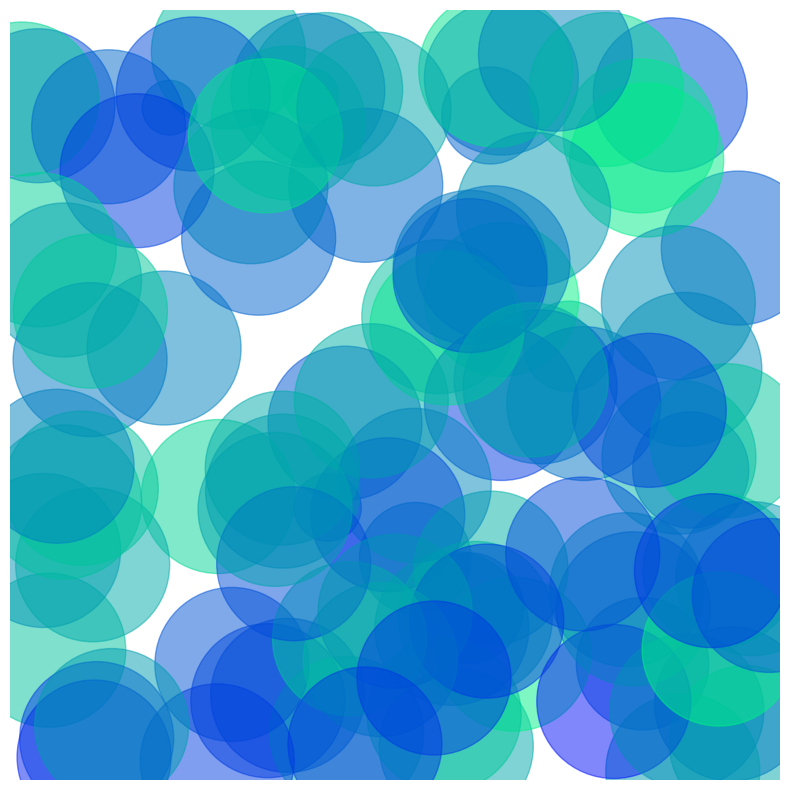

In [82]:
graphics.draw(network)

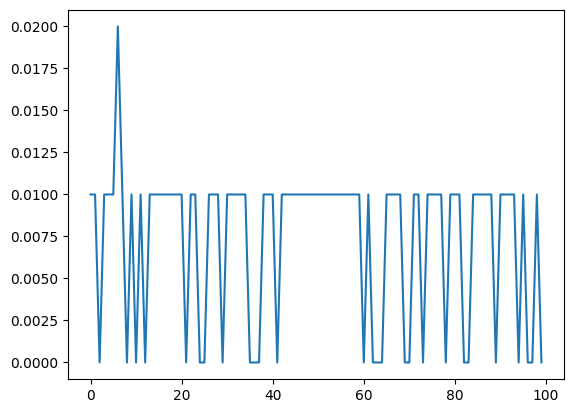

In [80]:
frs = []

for i in range(network.N):
    frs.append(network.neurons[i].firing_rate)
plt.plot(frs)